In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

import random

## Language dataset

In [98]:
class LanguageDataset(Dataset):
    '''
    Args:
    - min_length (int):  minimum length of the generated sequences
    - max_length (int):  maximum length of the generated sequences
    - p (float):         probability of generating a valid sequence
    - num_samples (int): number of samples to generate
    
    Returns:
    list of tuples (sequence, label) where sequence is a one-hot encoded tensor and label is 0 or 1.
    '''
    def __init__(self, min_length, max_length, p, num_samples):
        self.min_length = min_length
        self.max_length = max_length
        self.p = p
        self.num_samples = num_samples
        self.samples = self.generate_samples()
        self.avg_len = self.average_length(self.samples)
    
    def generate_samples(self):
        n = self.num_samples // 2
        valid_samples_train = []
        len3 = self.max_length // 3
        for _ in range(n):
            for length in range(n//len3):
                sequence = 'a' * length + 'b' * length + 'c' * length
                valid_samples_train.append(sequence, int(self.is_language(sequence)))
        invalid_samples = []
        for _ in range(n):
            sequence = self.generate_invalid_sequence(length)
            if self.is_language(sequence) == False:
                invalid_samples.append(sequence, int(self.is_language(sequence)))
            else:
                sequence[0] = np.random.choice(['b', 'c'])
                invalid_samples.append(sequence, int(self.is_language(sequence)))
        samples = valid_samples_train + invalid_samples
        samples = random.shuffle(samples)


        
        return samples
    
    def generate_invalid_sequence(self, length):
        sequence = ''.join(np.random.choice(['a', 'b', 'c'], size=length))
        while self.is_language(sequence):
            sequence = ''.join(np.random.choice(['a', 'b', 'c'], size=length))
        return sequence
    
    def is_language(self, sequence):
        counts = {'a': 0, 'b': 0, 'c': 0}
        for char in sequence:
            counts[char] += 1
        return counts['a'] == counts['b'] == counts['c']

    def average_length(self, samples):
        return np.mean([len(sequence) for sequence, _ in self.samples])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sequence, label = self.samples[idx]
        indices = torch.tensor([ord(c) - ord('a') for c in sequence], dtype=torch.long)
        one_hot_sequence = torch.nn.functional.one_hot(indices, num_classes=3).float()
        return one_hot_sequence, torch.tensor(label)

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return sequences_padded, labels


def generate_data(min_length, max_length, p, num_samples, batch_size=32):
    dataset = LanguageDataset(min_length, max_length, p, num_samples)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    return data_loader

## Model definition

In [99]:
class LSTM(nn.Module):
    '''
    Args:
    - input_size (int):     The number of input features per time step (e.g., 3 for 'a', 'b', 'c')
    - hidden_size (int):    The number of features in the hidden state of the LSTM
    - output_size (int):    The number of output classes (e.g., 2 for binary classification)
    - n_layers (int):       The number of recurrent layers in the LSTM
    
    Returns:
    The predicted output after passing through the LSTM model.
    '''
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input.size(0))
        output, (hidden, cell) = self.lstm(input)
        output = self.fc(output[:, -1, :])  # Use the output of the last time step
        output = self.softmax(output)
        return output

    def init_hidden(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size),
                torch.zeros(self.n_layers, batch_size, self.hidden_size))

## Training and evaluation functions

In [100]:
def eval_model(model, data_loader, criterion='accuracy'):
    '''
    Args:
    - model (nn.Module):        The trained model
    - data_loader (DataLoader): The DataLoader for the evaluation data
    - criterion (str):          The evaluation criterion ('accuracy' or 'f1')

    Returns:
    The evaluation score (accuracy or F1) of the model on the evaluation data.
    '''
    model.eval()  # Set model to eval mode
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # Deactivate gradients for the following code
        for sequences, labels in data_loader:  # Iterate over batches
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    if criterion == 'accuracy':
        return accuracy_score(true_labels, pred_labels)
    elif criterion == 'f1':
        return f1_score(true_labels, pred_labels)
    else:
        raise ValueError("Invalid criterion. Choose 'accuracy' or 'f1'.")

In [101]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    '''
    Args:
    - model (nn.Module):         The model to train
    - train_loader (DataLoader): The DataLoader for the training data
    - val_loader (DataLoader):   The DataLoader for the validation data
    - criterion (nn.Module):     The loss function
    - optimizer (torch.optim):   The optimizer
    - num_epochs (int):          The number of epochs to train
    
    Returns:
    The best model found during training with the corresponding best validation accuracy obtained.
    '''
    best_val_f1 = 0
    best_val_acc = 0
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()


        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')
        total_loss = 0
        
        # Evaluate the model on the validation set using the eval_model function
        val_f1 = eval_model(model, val_loader, criterion='f1')
        val_acc = eval_model(model, val_loader, criterion='accuracy')
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            best_model = model
        '''
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            best_model = model
        '''

    return best_model, best_val_f1, best_val_acc

### Generate data

In [102]:
# After generating the data loader, split it into train and validation sets
train_data_loader = generate_data(1, 20, 0.5, 1000, 32)

train_size = int(0.7 * len(train_data_loader.dataset))

# select train_size number of samples for training
train_data, val_data = random_split(train_data_loader.dataset, [train_size, len(train_data_loader.dataset) - train_size])

test_data = generate_data(21, 100, 0.5, 1000, 32).dataset

# Create separate data loaders for train, validation, and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [109]:
model = LSTM(3, 4, 2)
criterion = nn.CrossEntropyLoss()
        #criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))
optimizer = optim.Adam(model.parameters(), lr=0.001)
        
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

Epoch 1/30, Loss: 0.5778
Epoch 2/30, Loss: 0.5628
Epoch 3/30, Loss: 0.5495
Epoch 4/30, Loss: 0.5367
Epoch 5/30, Loss: 0.5252
Epoch 6/30, Loss: 0.5141
Epoch 7/30, Loss: 0.5030
Epoch 8/30, Loss: 0.4909
Epoch 9/30, Loss: 0.4817
Epoch 10/30, Loss: 0.4748
Epoch 11/30, Loss: 0.4714
Epoch 12/30, Loss: 0.4685
Epoch 13/30, Loss: 0.4665
Epoch 14/30, Loss: 0.4653
Epoch 15/30, Loss: 0.4644
Epoch 16/30, Loss: 0.4636
Epoch 17/30, Loss: 0.4631
Epoch 18/30, Loss: 0.4626
Epoch 19/30, Loss: 0.4619
Epoch 20/30, Loss: 0.4622
Epoch 21/30, Loss: 0.4611
Epoch 22/30, Loss: 0.4605
Epoch 23/30, Loss: 0.4603
Epoch 24/30, Loss: 0.4608
Epoch 25/30, Loss: 0.4603
Epoch 26/30, Loss: 0.4595
Epoch 27/30, Loss: 0.4593
Epoch 28/30, Loss: 0.4594
Epoch 29/30, Loss: 0.4592
Epoch 30/30, Loss: 0.4593


(None, 0, 0)

In [103]:
labels = [label for _, label in train_loader.dataset]
class_counts = np.bincount(labels)
class_weights = 1.0 / class_counts

weights = [class_weights[label] for label in labels]
weights = torch.tensor(weights, dtype=torch.float)
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

In [112]:
# loop through first batch
for sequences, labels in train_loader:
    print(model(sequences))
    print(labels)
    break

tensor([[0.9887, 0.0113],
        [0.9888, 0.0112],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9906, 0.0094],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9890, 0.0110],
        [0.9887, 0.0113],
        [0.9900, 0.0100],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9890, 0.0110],
        [0.9887, 0.0113],
        [0.9887, 0.0113],
        [0.9888, 0.0112]], grad_fn=<SoftmaxBackward0>)
tensor([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [104]:
#train_loader = DataLoader(train_data, batch_size=32, sampler=sampler, collate_fn=collate_fn)

## Hyperparameter tuning

In [105]:
input_size = 3  # 'a', 'b', 'c'
output_size = 2  # 0 or 1
hidden_sizes = [16, 32, 64]
learning_rates = [0.001, 0.01, 0.1]

best_val_acc = 0
best_val_f1 = 0
best_model_acc = None
best_model_f1 = None

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        model = LSTM(input_size, hidden_size, output_size)
        criterion = nn.CrossEntropyLoss()
        #criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        model, val_f1, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
        print (val_acc)
        print (val_f1)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_acc = model
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_f1 = model

print(f'Best validation accuracy: {np.round(best_val_acc,3)}')
print (best_model_acc)

print(f'Best validation F1: {np.round(best_val_f1,3)}')
print (best_model_f1)

Epoch 1/10, Loss: 0.6644
Epoch 2/10, Loss: 0.6155
Epoch 3/10, Loss: 0.5289
Epoch 4/10, Loss: 0.4755
Epoch 5/10, Loss: 0.4653
Epoch 6/10, Loss: 0.4615
Epoch 7/10, Loss: 0.4597
Epoch 8/10, Loss: 0.4581
Epoch 9/10, Loss: 0.4577
Epoch 10/10, Loss: 0.4583
0
0
Epoch 1/10, Loss: 0.5168
Epoch 2/10, Loss: 0.4564
Epoch 3/10, Loss: 0.4567
Epoch 4/10, Loss: 0.4566
Epoch 5/10, Loss: 0.4568
Epoch 6/10, Loss: 0.4558
Epoch 7/10, Loss: 0.4562
Epoch 8/10, Loss: 0.4566
Epoch 9/10, Loss: 0.4560
Epoch 10/10, Loss: 0.4562
0
0
Epoch 1/10, Loss: 0.4659
Epoch 2/10, Loss: 0.4563
Epoch 3/10, Loss: 0.4565
Epoch 4/10, Loss: 0.4555
Epoch 5/10, Loss: 0.4565
Epoch 6/10, Loss: 0.4561
Epoch 7/10, Loss: 0.4561
Epoch 8/10, Loss: 0.4557
Epoch 9/10, Loss: 0.4563
Epoch 10/10, Loss: 0.4563
0
0
Epoch 1/10, Loss: 0.6812
Epoch 2/10, Loss: 0.5744
Epoch 3/10, Loss: 0.4668
Epoch 4/10, Loss: 0.4580
Epoch 5/10, Loss: 0.4571
Epoch 6/10, Loss: 0.4569
Epoch 7/10, Loss: 0.4567
Epoch 8/10, Loss: 0.4565
Epoch 9/10, Loss: 0.4568
Epoch 10/1

KeyboardInterrupt: 

## Evaluation

In [ ]:
best_model = best_model_f1

# Evaluate the model on the validation set
val_accuracy = eval_model(best_model, val_loader, criterion='accuracy')
val_f1_score = eval_model(best_model, val_loader, criterion='f1')

print(f'Validation Accuracy: {np.round(val_accuracy,3)}')
print(f'Validation F1 Score: {val_f1_score}')

# Evaluate the model on the test set
test_accuracy = eval_model(best_model, test_loader, criterion='accuracy')
test_f1_score = eval_model(best_model, test_loader, criterion='f1')

print(f'Test Accuracy: {np.round(test_accuracy,3)}')
print(f'Test F1 Score: {test_f1_score}')

Validation Accuracy: 0.85
Validation F1 Score: 0.0
Test Accuracy: 0.83
Test F1 Score: 0.0


## Plot results

In [ ]:
# Initialize lists to store performance metrics
accuracy_per_length = []
f1_score_per_length = []

# Evaluate the model on sequences of lengths ranging from 21 to 100
for length in range(21, 101):
    test_data = generate_data(length, length, 0.5, 1000, 32).dataset
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
    
    # Evaluate the model on the test set
    test_accuracy = eval_model(best_model, test_loader, criterion='accuracy')
    test_f1_score = eval_model(best_model, test_loader, criterion='f1')
    
    accuracy_per_length.append(test_accuracy)
    f1_score_per_length.append(test_f1_score)

/Users/ellenebdrup/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ellenebdrup/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ellenebdrup/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [ ]:
# Load vanilla RNN
rnn_accuracy_per_length = np.loadtxt('RNN_acc.csv', delimiter=',')
rnn_f1_score_per_length = np.loadtxt('RNN_f1.csv', delimiter=',')

## Plot results from LSTM

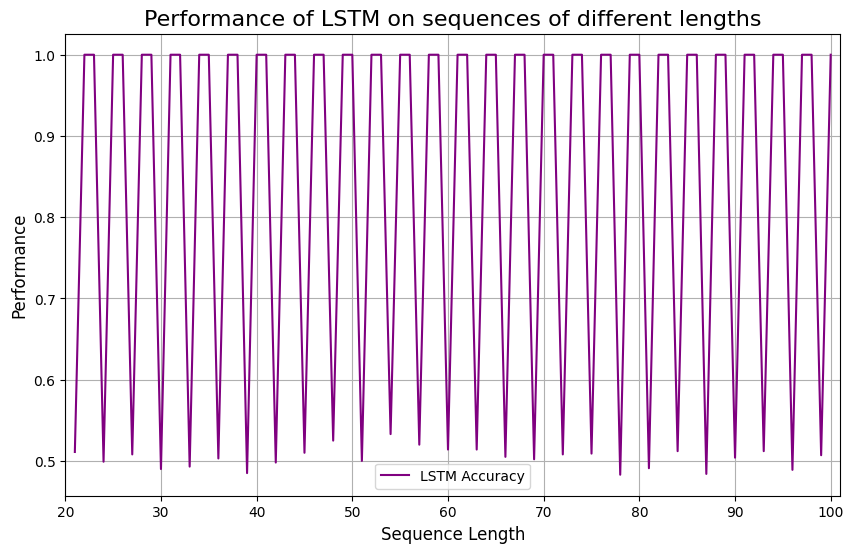

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), accuracy_per_length, label='LSTM Accuracy', color='purple')
plt.xlim(20, 101)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.title('Performance of LSTM on sequences of different lengths', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

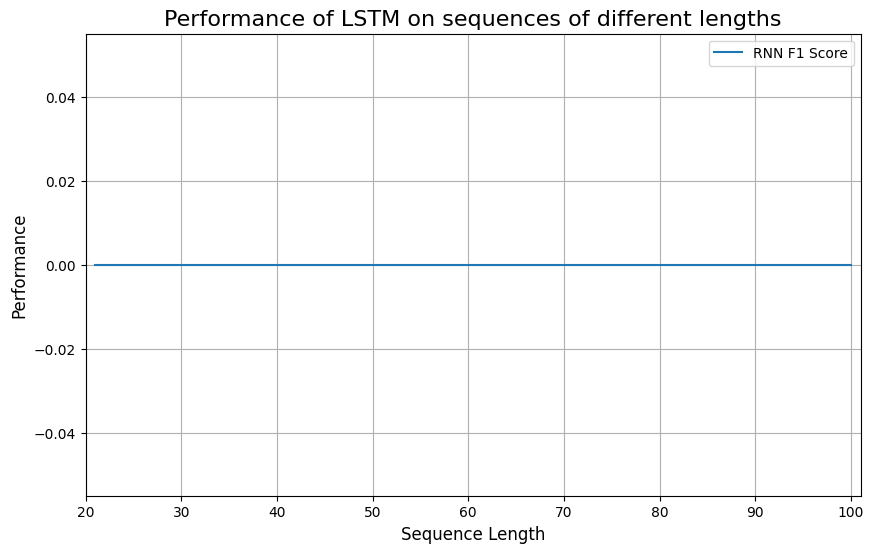

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), f1_score_per_length, label='RNN F1 Score')
plt.xlim(20, 101)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.title('Performance of LSTM on sequences of different lengths', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

## Plot results from LSTM and RNN

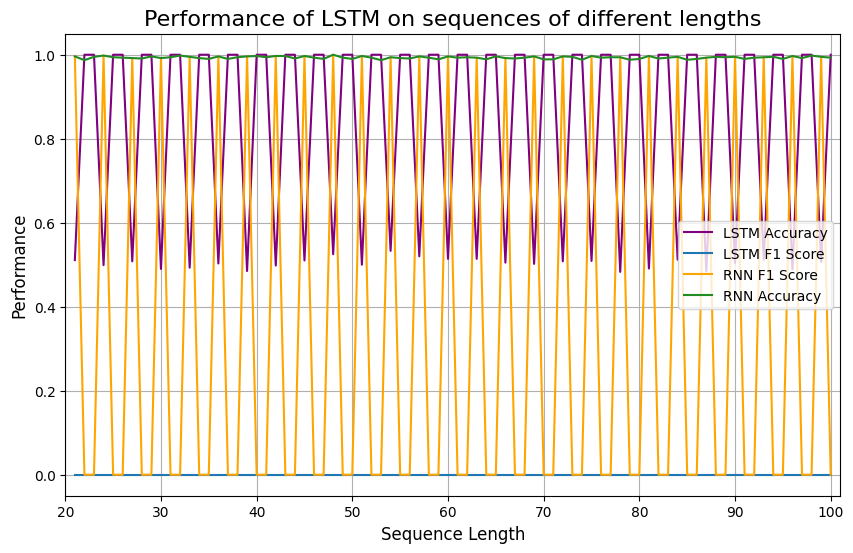

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), accuracy_per_length, label='LSTM Accuracy', color='purple')
plt.plot(range(21, 101), f1_score_per_length, label='LSTM F1 Score')
plt.plot(range(21, 101), rnn_f1_score_per_length, label='RNN F1 Score', color='orange')
plt.plot(range(21, 101), rnn_accuracy_per_length, label='RNN Accuracy', color='forestgreen')
#plt.ylim(0.997, 1)
plt.xlim(20, 101)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.title('Performance of LSTM on sequences of different lengths', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()